<a href="https://colab.research.google.com/github/joaovitormascarenhas/cnn_tutotial/blob/master/cnn_cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introdução à Redes Neurais Convolucionais - ConvNets/CNNs  
---





In [0]:
%matplotlib inline

## Exemplo: Classificação de Imagens

Vamos aprender a implementar os seguintes passos:

1. Carregar e normalizar o conjunto de dados CIFAR10
2. Definir a estrutura de uma Rede Neural Convolucional
3. Definir um loop de treinamento
4. Treinar e testar a Rede Neural



## Carregar e normalizar o conjunto de dados CIFAR10

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:02, 70571910.55it/s]                               


Files already downloaded and verified


### Exibindo algumas imagens do conjunto de dados
<img src="https://github.com/jjviana/QConSP2018/blob/master/cifar10.png?raw=1" >

       car       bird        car       bird


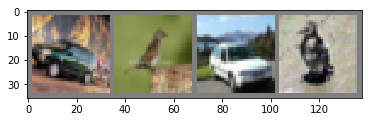

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Definindo a estrutura da Rede Neural

<img src="https://github.com/jjviana/QConSP2018/blob/master/cifar10network.png?raw=1">

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Função de perda e otimizador

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Loop de Treino


In [7]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        #Forward
        inputs, labels = data
        outputs = net(inputs)
        
        #Backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.233
[1,  4000] loss: 1.916
[1,  6000] loss: 1.726
[1,  8000] loss: 1.627
[1, 10000] loss: 1.574
[1, 12000] loss: 1.508
[2,  2000] loss: 1.456
[2,  4000] loss: 1.394
[2,  6000] loss: 1.391
[2,  8000] loss: 1.383
[2, 10000] loss: 1.360
[2, 12000] loss: 1.324
Finished Training


In [16]:
#torch.save(net.state_dict(),'cifar10.dat')
net.load_state_dict(torch.load('cifar10.dat'))

FileNotFoundError: ignored

## Testando o modelo

### Algumas imagens:


In [0]:
dataiter = iter(testloader)
# Carrega 4 imagens por default
images, labels = dataiter.next()


In [15]:
outputs = net(images)
print(outputs)

tensor([[-1.6715, -1.6176,  1.2078,  2.5969, -0.6249,  1.2449,  1.7023, -0.6693,
         -1.2257, -0.2614],
        [ 3.3140,  5.4794, -0.8136, -1.7192, -3.1520, -4.1616, -2.7939, -3.6972,
          3.8513,  4.7949],
        [ 1.2674,  4.8553, -0.6013, -0.9130, -3.2568, -2.6090, -1.8453, -2.9740,
          2.3517,  4.5808],
        [ 4.2828,  0.6248,  1.3471, -0.9661,  0.1604, -3.0216, -1.5736, -3.8912,
          3.4723, -0.2566]], grad_fn=<AddmmBackward>)


In [0]:
probabilities=torch.exp(outputs)
line_sum=probabilities.sum(1).unsqueeze(0).transpose(0,1)
probabilities=100*(probabilities/line_sum)


In [0]:
def plot_classes(probabilities):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.barh(y=[i for i in range(0,probabilities.size(0))],
            width=[probabilities[i] for i in range(0,probabilities.size(0)) ],
           tick_label= classes)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.show()
    

Ground truth: cat


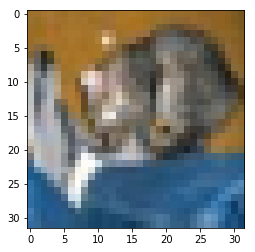

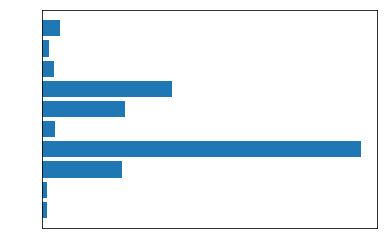

Ground truth: ship


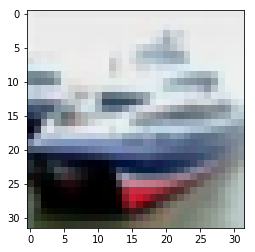

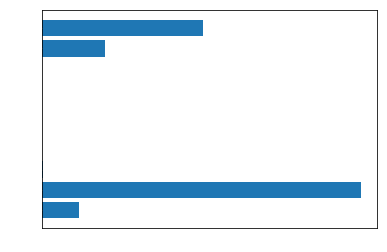

Ground truth: ship


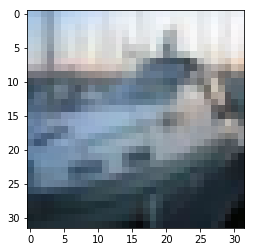

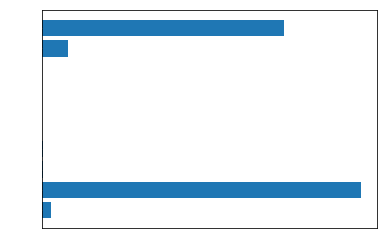

Ground truth: plane


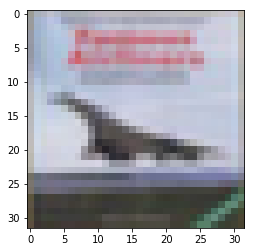

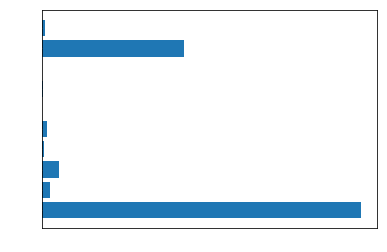

In [19]:
def show_output(n):
    imshow(torchvision.utils.make_grid(images[n]))
    print("Ground truth: "+classes[labels[n]])
    plot_classes(probabilities[n].detach())
 
for i in range(0,4):
    show_output(i)

### Calculando acuracia

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 46 %
Accuracy of   car : 61 %
Accuracy of  bird : 36 %
Accuracy of   cat : 42 %
Accuracy of  deer : 32 %
Accuracy of   dog : 32 %
Accuracy of  frog : 78 %
Accuracy of horse : 55 %
Accuracy of  ship : 65 %
Accuracy of truck : 73 %


## Treinando na GPU


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Enviando modelos para a GPU:

    inputs, labels = inputs.to(device), labels.to(device)
    net.to(device)

       
